In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd

## First, let's load, normalize, and visualize the MNIST dataset.



In [5]:
def load_MNIST():
  """Function to load and normalize MNIST data"""
  train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  test = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  print("MNIST datset loaded and normalized.")
  train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=256)
  test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=False, batch_size=256)
  print("PyTorch DataLoaders loaded.")
  return train, test, train_loader, test_loader


In [6]:
# load and visualize MNISt
train, test, train_loader, test_loader = load_MNIST()

MNIST datset loaded and normalized.
PyTorch DataLoaders loaded.


## Now let's build a vanilla neural net with four hidden layers without pruning.

We'll keep things simple and leave out biases, convolutions, and pooling.

In [7]:
class Net(nn.Module):
  """A non-sparse neural network with four hidden fully-connected layers"""

  def __init__(self):
    super(Net,self).__init__()
    self.input_layer = nn.Linear(784, 1000, bias=False)
    self.hidden1_layer = nn.Linear(1000, 1000, bias=False)
    self.hidden2_layer = nn.Linear(1000, 500, bias=False)
    self.hidden3_layer = nn.Linear(500, 200, bias=False)
    self.hidden4_layer = nn.Linear(200, 10, bias=False)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    x = self.hidden1_layer(x)
    x = F.relu(x)
    x = self.hidden2_layer(x)
    x = F.relu(x)
    x = self.hidden3_layer(x)
    x = F.relu(x)
    x = self.hidden4_layer(x)
    output = F.log_softmax(x, dim=1)

    return output

## Let's train our vanilla neural net.

In [8]:
def train(model, train_loader, epochs=3, learning_rate=0.001):
  """Function to train a neural net"""

  lossFunction = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  time0 = time()
  total_samples = 0

  for e in range(epochs):
    print("Starting epoch", e)
    total_loss = 0

    for idx, (images,labels) in enumerate(train_loader):
      images = images.view(images.shape[0],-1) # flatten
      optimizer.zero_grad() # forward pass
      output = model(images)
      loss = lossFunction(output,labels) # calculate loss
      loss.backward() # backpropagate
      optimizer.step() # update weights

      total_samples += labels.size(0)
      total_loss += loss.item()

      if idx % 100 == 0:
        print("Running loss:", total_loss/(idx+1))

  final_time = (time()-time0)/60
  print("Model trained in ", final_time, "minutes on ", total_samples, "samples")


In [9]:
model = Net()
train(model, train_loader)

Starting epoch 0
Running loss: 2.3034982681274414
Running loss: 0.6723827660673916
Running loss: 0.45077266636772534
Starting epoch 1
Running loss: 0.15646836161613464
Running loss: 0.15484687936778116
Running loss: 0.14806751654812353
Starting epoch 2
Running loss: 0.13929077982902527
Running loss: 0.0956116105881658
Running loss: 0.10142881799470727
Model trained in  1.552357014020284 minutes on  180000 samples


## Now we'll test our vanilla neural net.

In [10]:
def test(model, test_loader):
  """Test neural net"""

  correct = 0
  total = 0

  with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
      images = images.view(images.shape[0],-1) # flatten
      output = model(images)
      values, indices = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (labels == indices).sum().item()

    acc = correct / total * 100
    # print("Accuracy: ", acc, "% for ", total, "training samples")

  return acc

In [11]:
acc = test(model, test_loader)
print("The accuracy of our vanilla NN is", acc, "%")

The accuracy of our vanilla NN is 94.66 %


## A ~96% accuracy for our vanilla NN seems reasonable. Now let's do some weight and unit pruning.

In [12]:

def sparsify_by_weights(model, k):
  """Function that takes un-sparsified neural net and does weight-pruning
  by k sparsity"""

  # make copy of original neural net
  sparse_m = copy.deepcopy(model)

  with torch.no_grad():
    for idx, i in enumerate(sparse_m.parameters()):
      if idx == 4: # skip last layer of 5-layer neural net
        break
      # change tensor to numpy format, then set appropriate number of smallest weights to zero
      layer_copy = torch.flatten(i)
      layer_copy = layer_copy.detach().numpy()
      indices = abs(layer_copy).argsort() # get indices of smallest weights by absolute value
      indices = indices[:int(len(indices)*k)] # get k fraction of smallest indices
      layer_copy[indices] = 0

      # change weights of model
      i = torch.from_numpy(layer_copy)

  return sparse_m

In [13]:
def l2(array):
  return np.sqrt(np.sum([i**2 for i in array]))

def sparsify_by_unit(model, k):
  """Creates a k-sparsity model with unit-level pruning that sets columns with smallest L2 to zero."""

  # make copy of original neural net
  sparse_m = copy.deepcopy(model)

  for idx, i in enumerate(sparse_m.parameters()):
    if idx == 4: # skip last layer of 5-layer neural net
      break
    layer_copy = i.detach().numpy()
    indices = np.argsort([l2(i) for i in layer_copy])
    indices = indices[:int(len(indices)*k)]
    layer_copy[indices,:] = 0
    i = torch.from_numpy(layer_copy)

  return sparse_m


In [16]:
def get_pruning_accuracies(model, prune_type):
  """ Takes a model and prune type ("weight" or "unit") and returns a DataFrame of pruning accuracies for given sparsities."""

  df = pd.DataFrame({"sparsity": [], "accuracy": []})
  sparsities = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

  for s in sparsities:
    if prune_type == "weight":
      new_model = sparsify_by_weights(model, s)
    elif prune_type == "unit":
      new_model = sparsify_by_unit(model, s)
    else:
      print("Must specify prune-type.")
      return
    acc = test(new_model, test_loader)

    new_row = pd.DataFrame([{"sparsity": s, "accuracy": acc}])
    df = pd.concat([df, new_row], ignore_index=True)


  return df

## Results

In [17]:
df_weight = get_pruning_accuracies(model, "weight")
df_unit = get_pruning_accuracies(model, "unit")

print("Accuracies for Weight Pruning")
print(df_weight)

print()

print("Accuracies for Unit Pruning")
print(df_unit)

Accuracies for Weight Pruning
   sparsity  accuracy
0      0.00     94.66
1      0.25     94.74
2      0.50     93.93
3      0.60     94.11
4      0.70     94.18
5      0.80     93.44
6      0.90     85.43
7      0.95     67.65
8      0.97     51.61
9      0.99     32.42

Accuracies for Unit Pruning
   sparsity  accuracy
0      0.00     94.66
1      0.25     94.76
2      0.50     93.72
3      0.60     90.63
4      0.70     89.15
5      0.80     58.41
6      0.90     21.82
7      0.95     18.28
8      0.97     10.66
9      0.99     10.99


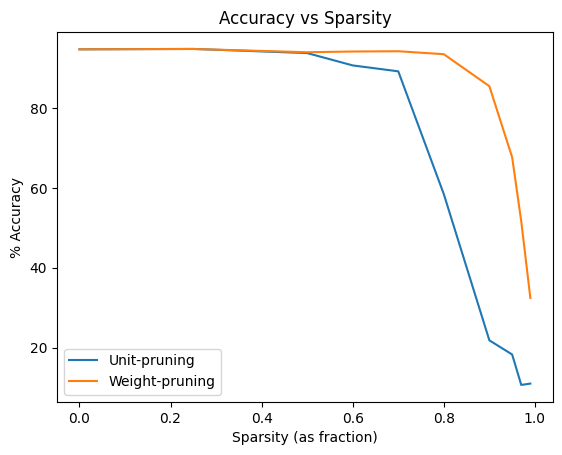

In [18]:
plt.figure()
plt.title("Accuracy vs Sparsity")
plt.plot(df_unit["sparsity"], df_unit["accuracy"], label="Unit-pruning")
plt.plot(df_weight["sparsity"], df_weight["accuracy"], label="Weight-pruning")
plt.xlabel("Sparsity (as fraction)")
plt.ylabel("% Accuracy")
plt.legend()